Ref: https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = [12, 6]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################
plt.rcParams.update({'axes.grid'     : True})

## Import data

In [3]:
data = pd.read_csv('../data/num_file/hrs_01/p040.csv')

In [4]:
print(data)

                 datetime  count
0     2022-04-21 01:00:00   1033
1     2022-04-21 02:00:00     65
2     2022-04-21 03:00:00      0
3     2022-04-21 04:00:00      0
4     2022-04-21 05:00:00      0
...                   ...    ...
3246  2022-09-03 07:00:00   9741
3247  2022-09-03 08:00:00  19613
3248  2022-09-03 09:00:00  22055
3249  2022-09-03 10:00:00  14644
3250  2022-09-03 11:00:00  12751

[3251 rows x 2 columns]


If there is no people, use NaN.

In [5]:
data.loc[data['count']==0, 'count'] = np.NaN

In [6]:
print(data)

                 datetime    count
0     2022-04-21 01:00:00   1033.0
1     2022-04-21 02:00:00     65.0
2     2022-04-21 03:00:00      NaN
3     2022-04-21 04:00:00      NaN
4     2022-04-21 05:00:00      NaN
...                   ...      ...
3246  2022-09-03 07:00:00   9741.0
3247  2022-09-03 08:00:00  19613.0
3248  2022-09-03 09:00:00  22055.0
3249  2022-09-03 10:00:00  14644.0
3250  2022-09-03 11:00:00  12751.0

[3251 rows x 2 columns]


<Axes: >

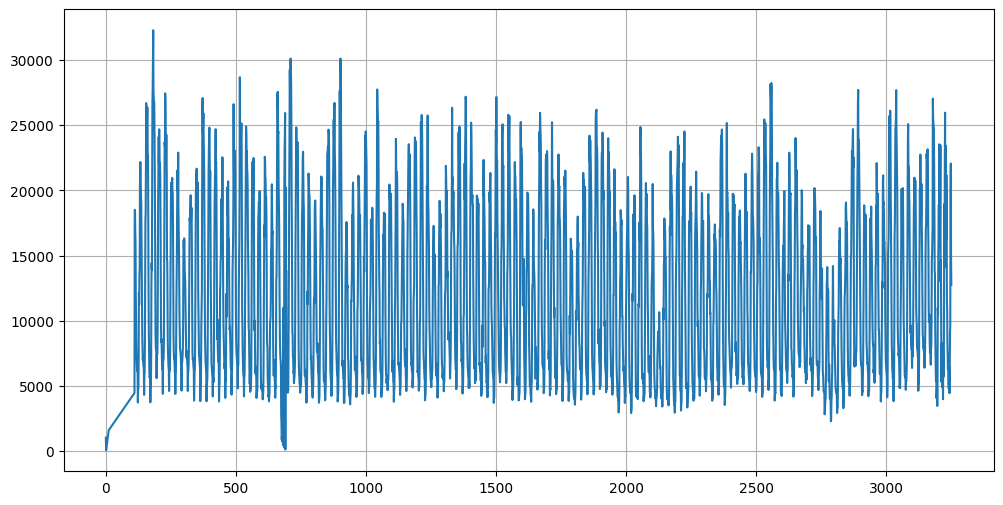

In [7]:
data['count'] = data['count'].interpolate(method='linear')
data['count'].plot()

## Normalize data

<Axes: >

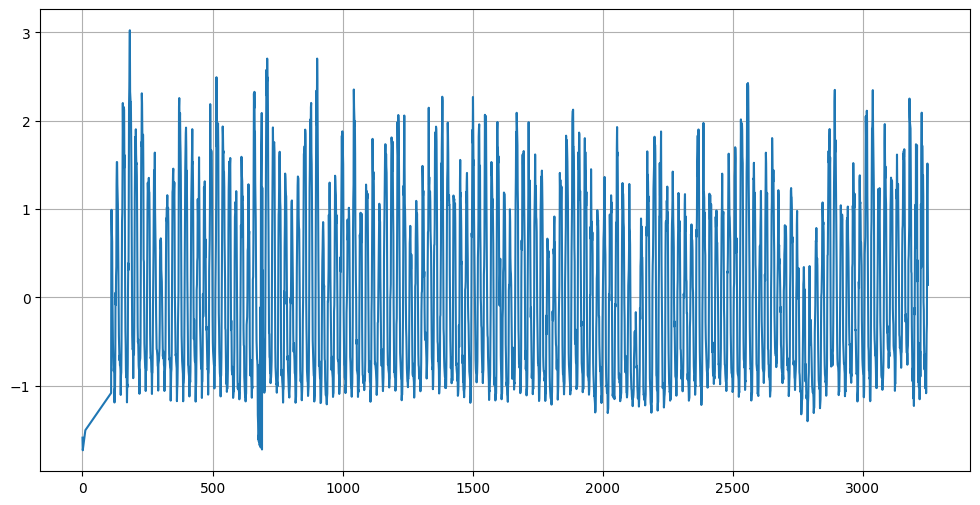

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['count'] = scaler.fit_transform(data[['count']])
data['count'].plot()

In [9]:
print(data)

                 datetime     count
0     2022-04-21 01:00:00 -1.588140
1     2022-04-21 02:00:00 -1.730996
2     2022-04-21 03:00:00 -1.708284
3     2022-04-21 04:00:00 -1.685572
4     2022-04-21 05:00:00 -1.662859
...                   ...       ...
3246  2022-09-03 07:00:00 -0.303021
3247  2022-09-03 08:00:00  1.153879
3248  2022-09-03 09:00:00  1.514267
3249  2022-09-03 10:00:00  0.420559
3250  2022-09-03 11:00:00  0.141192

[3251 rows x 2 columns]


In [10]:
encode_input_data = []
decode_input_data = []
decode_output_data = []
time_step = 12

for i in range(len(data)-time_step-1):
    encode_input_data.append(data['count'].values[i:i+time_step])
    decode_input_data.append(data['count'].values[i:i+time_step])
    decode_output_data.append(data['count'].values[i+1:i+time_step+1])

encode_input_data = np.array(encode_input_data)
decode_input_data = np.array(decode_input_data)
decode_output_data = np.array(decode_output_data)

In [11]:
encode_input_data = encode_input_data.reshape(encode_input_data.shape[0], encode_input_data.shape[1], 1)
decode_input_data = decode_input_data.reshape(decode_input_data.shape[0], decode_input_data.shape[1], 1)
decode_output_data = decode_output_data.reshape(decode_output_data.shape[0], decode_output_data.shape[1], 1)

In [12]:
train_size = int(len(encode_input_data)*0.8)
encode_input_data_train = encode_input_data[:train_size]
decode_input_data_train = decode_input_data[:train_size]
decode_output_data_train = decode_output_data[:train_size]
encode_input_data_test = encode_input_data[train_size:]
decode_input_data_test = decode_input_data[train_size:]
decode_output_data_test = decode_output_data[train_size:]

## Model

In [13]:
from keras.layers import Input, LSTM, BatchNormalization, RepeatVector, TimeDistributed, Dense, dot, multiply, concatenate, Activation, GRU
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [14]:
input_train = Input(shape=(time_step, 1))
output_train = Input(shape=(time_step, 1))

In [15]:
'''
lstm_1 = LSTM(32, return_sequences=True, return_state=False)(input_train)
norm_lstm_1 = BatchNormalization()(lstm_1)
'''

'\nlstm_1 = LSTM(32, return_sequences=True, return_state=False)(input_train)\nnorm_lstm_1 = BatchNormalization()(lstm_1)\n'

In [16]:
# encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(32, activation='relu', return_sequences=False, return_state=True)(input_train)
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(32, return_sequences=False, return_state=True)(input_train)

2024-05-03 16:39:52.953330: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-03 16:39:52.953353: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-03 16:39:52.953360: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-03 16:39:52.953380: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-03 16:39:52.953394: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
encoder_last_h1 = BatchNormalization()(encoder_last_h1)
encoder_last_c = BatchNormalization()(encoder_last_c)

In [18]:
decoder = RepeatVector(time_step)(encoder_last_h1)
# decoder = LSTM(32, activation='relu', return_state=False, return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])
decoder = LSTM(32, return_state=False, return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])

In [19]:
# lstm_decode = LSTM(32, return_sequences=True, return_state=False)(decoder)

In [20]:
out = TimeDistributed(Dense(1))(decoder)

In [21]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 12, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 32),      │      4,352 │ input_layer[0][0] │
│                     │ (None, 32),       │            │                   │
│                     │ (None, 32)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32)        │        128 │ lstm[0][0]        │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 12, 32)    │          0 │ batch_normalizat… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ lstm[0][2]        │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 12, 32)    │      8,320 │ repeat_vector[0]… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 12, 1)     │         33 │ lstm_1[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,961 (50.63 KB)

 Trainable params: 12,833 (50.13 KB)

 Non-trainable params: 128 (512.00 B)

In [22]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_activations=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [23]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
history = model.fit(encode_input_data_train, decode_output_data_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[es], shuffle=True)

Epoch 1/100


2024-05-03 16:39:53.818498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.8265 - mae: 0.7124 - val_loss: 0.4853 - val_mae: 0.6058
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1759 - mae: 0.3129 - val_loss: 0.4448 - val_mae: 0.5785
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.1136 - mae: 0.2496 - val_loss: 0.4492 - val_mae: 0.5704
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1141 - mae: 0.2408 - val_loss: 0.3756 - val_mae: 0.5223
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0892 - mae: 0.2155 - val_loss: 0.3098 - val_mae: 0.4739
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0693 - mae: 0.1888 - val_loss: 0.2772 - val_mae: 0.4390
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0713 - mae: 0.1892 - val_loss: 0.2501 - val_mae: 0.4195
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0759 - mae: 0.1958 - val_loss: 0.2254 - val_mae: 0.3797
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0864 

In [24]:
# model.save('./params/p040_seq2seq.keras')

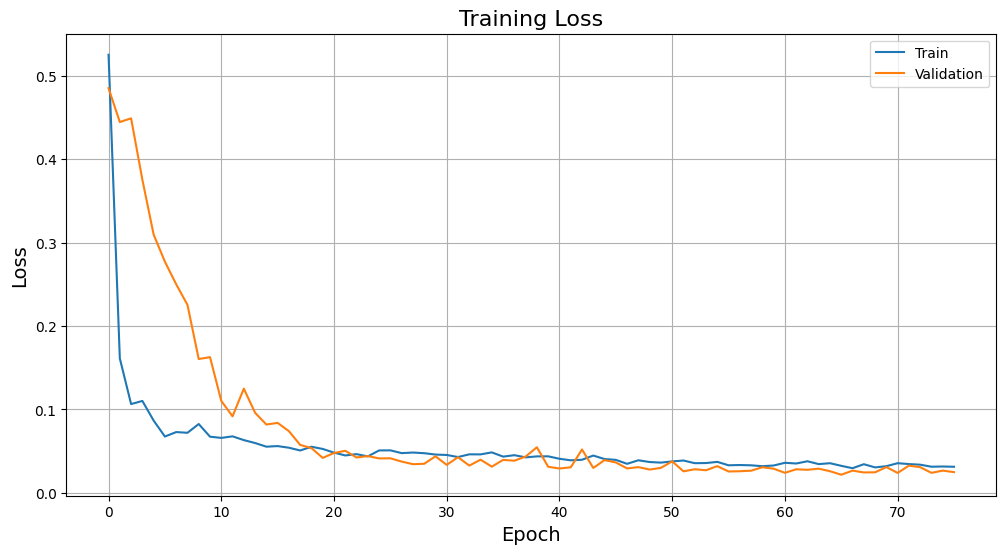

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [26]:
predict_train = model.predict(encode_input_data_train)

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [27]:
predict_test = model.predict(encode_input_data_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [28]:
print(predict_train.shape)

(2590, 12, 1)


In [29]:
print(predict_test.shape)

(648, 12, 1)


In [30]:
predict = np.concatenate([predict_train, predict_test], axis=0)
print(predict.shape)

(3238, 12, 1)


In [31]:
print(predict_test[:, -1, :])

[[ 2.14702681e-01]
 [ 5.93002200e-01]
 [ 8.53835166e-01]
 [ 1.03407538e+00]
 [ 6.71399117e-01]
 [ 7.77748168e-01]
 [ 9.44734454e-01]
 [ 1.17138016e+00]
 [ 8.60505581e-01]
 [-9.15619172e-03]
 [-5.80832124e-01]
 [-7.75444686e-01]
 [-7.97701120e-01]
 [-7.95917749e-01]
 [-7.96790659e-01]
 [-8.24362516e-01]
 [-8.78907561e-01]
 [-8.82078588e-01]
 [-8.92709851e-01]
 [-6.92082763e-01]
 [-3.98645490e-01]
 [ 6.35069236e-02]
 [ 6.43740594e-01]
 [ 4.35517937e-01]
 [ 1.21680689e+00]
 [ 1.50821030e+00]
 [ 1.68562615e+00]
 [ 1.53435194e+00]
 [ 1.29045820e+00]
 [ 1.18708193e+00]
 [ 1.06722057e+00]
 [ 9.48527098e-01]
 [ 1.70086592e-01]
 [-4.03231651e-01]
 [-7.01416016e-01]
 [-8.03931415e-01]
 [-8.84674072e-01]
 [-8.79966617e-01]
 [-9.02038157e-01]
 [-9.39373374e-01]
 [-9.51097667e-01]
 [-9.03908968e-01]
 [-9.47614491e-01]
 [-8.68420780e-01]
 [-7.94816494e-01]
 [-4.71927449e-02]
 [ 4.84324962e-01]
 [ 6.25666380e-01]
 [ 1.31695068e+00]
 [ 1.46978843e+00]
 [ 1.79765308e+00]
 [ 1.66758204e+00]
 [ 1.4233486

In [32]:
print(decode_output_data_test[:, -1, :])

[[ 0.31725334]
 [ 0.46807914]
 [ 0.58378113]
 [ 0.24907181]
 [ 0.76220422]
 [ 0.92395087]
 [ 1.20435109]
 [ 0.80544488]
 [ 0.10060727]
 [-0.27468629]
 [-0.39333986]
 [-0.46343991]
 [-0.66252407]
 [-0.80242902]
 [-0.8223522 ]
 [-0.83917621]
 [-0.8498019 ]
 [-0.9696361 ]
 [-0.85216317]
 [-0.81674419]
 [-0.46270202]
 [ 0.25984508]
 [ 0.18856439]
 [ 0.8603443 ]
 [ 1.19874309]
 [ 1.63734807]
 [ 1.51559534]
 [ 1.20139951]
 [ 1.18029571]
 [ 1.16007737]
 [ 1.17852476]
 [ 0.55884027]
 [-0.13699502]
 [-0.58224106]
 [-0.60113118]
 [-0.7560892 ]
 [-0.76671489]
 [-0.89451836]
 [-0.88492572]
 [-0.93333165]
 [-0.93613565]
 [-1.1240038 ]
 [-1.07692608]
 [-1.05287069]
 [-0.64437184]
 [ 0.09145737]
 [ 0.34942557]
 [ 0.93738057]
 [ 1.08274595]
 [ 1.80248904]
 [ 1.58156318]
 [ 1.35886637]
 [ 1.40358283]
 [ 1.30632823]
 [ 1.44003486]
 [ 1.01943453]
 [ 0.7179305 ]
 [ 0.51013918]
 [-0.18525338]
 [-0.40485102]
 [-0.54254229]
 [-0.636255  ]
 [-0.644667  ]
 [-0.66267165]
 [-0.64850406]
 [-0.7898848 ]
 [-0.68111

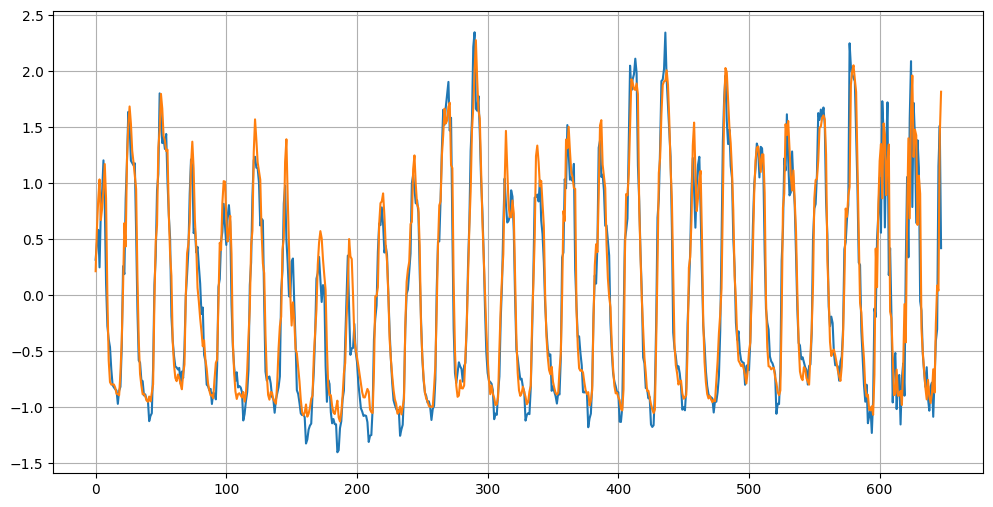

In [33]:
plt.plot(np.arange(decode_output_data_test.shape[0]), decode_output_data_test[:, -1, :])
plt.plot(np.arange(predict_test.shape[0]), predict_test[:, -1, :])
plt.show()

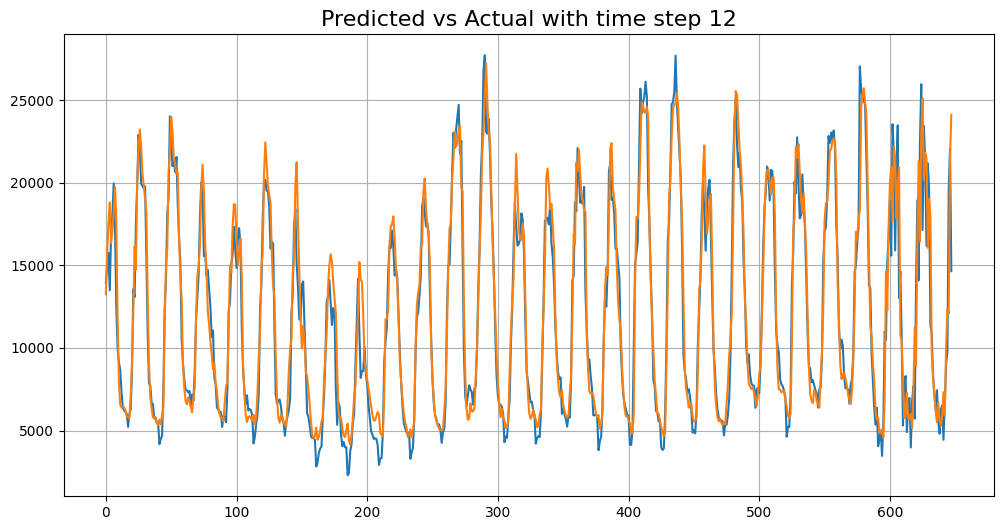

In [34]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])
decode_output_test_data = scaler.inverse_transform(decode_output_data_test[:, -1, :])
plt.plot(np.arange(decode_output_test_data.shape[0]), decode_output_test_data)
plt.plot(np.arange(predict_test_data.shape[0]), predict_test_data)
plt.title(f'Predicted vs Actual with time step {time_step}')
plt.show()

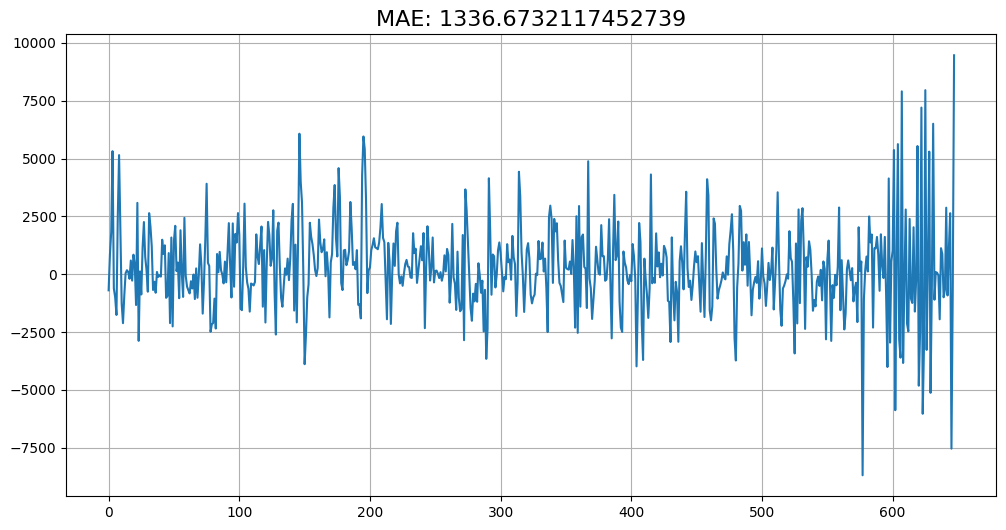

In [35]:
from sklearn.metrics import mean_absolute_error
plt.title('MAE: {}'.format(mean_absolute_error(decode_output_test_data, predict_test_data)))
plt.plot(np.arange(decode_output_test_data.shape[0]), predict_test_data-decode_output_test_data)
plt.show()